# Cryptocurrency Data Processing & Machine Learning

Parts of the code in this notebook may be taken from:
- Kirrane, S., "Data Processing II" Course Materials
- Datacamp, "Introduction to PySpark" Course Materials

### Opening a SparkSession

In [72]:
import findspark

# Initialize via the full spark path
findspark.init("/usr/local/spark/")

In [73]:
# Import the SparkSession module
from pyspark.sql import SparkSession

# Gets an existing :class:`SparkSession` or, if there is no existing one, creates a
# new one based on the options set in this builder.
spark = SparkSession.builder \
   .master("local") \
   .appName("CryptoProcessing") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
  
# Main entry point for Spark functionality. A SparkContext represents the
# connection to a Spark cluster, and can be used to create :class:`RDD` and
# broadcast variables on that cluster.    
sc = spark.sparkContext

import sys

## Pre-Processing of Crypto Data

In [74]:
from pyspark.sql.functions import explode

try:    
    #reading the data
    crypto_data = spark.read.json ("crypto_data_raw.json")

    #creating a temporary table
    crypto_data.createOrReplaceTempView("crypto_data")

    #we only select the currencies we need for the analysis
    crypto_select = spark.sql("SELECT * FROM crypto_data WHERE currency='BTC' OR currency='LTC' OR currency='ETH' OR currency='LINK' OR currency='DOGE'")

    #exploding the columns
    crypto_times = crypto_select.select("crypto_data.currency",explode("crypto_data.timestamps")).withColumnRenamed("col","timestamps")
    crypto_prices = crypto_select.select("crypto_data.currency",explode("crypto_data.prices")).withColumnRenamed("col","prices").drop("currency")

except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])

In [24]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window
from pyspark.sql.functions import monotonically_increasing_id,expr,to_timestamp,col,lag

try:
    spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

    # since there is no common column between these two dataframes we add row_index so that it can be joined
    crypto_times=crypto_times.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
    crypto_prices=crypto_prices.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

    #we join them
    crypto_final = crypto_times.join(crypto_prices, on=["row_index"]).drop("row_index").drop("currency.price")
    
    #we convert from a string to the unix date-time format
    crypto_final = crypto_final.withColumn("timestamps",to_timestamp(col("timestamps"), "yyyy-MM-dd'T'HH:mm:ss'Z'"))

    #creating the daily movement in price
    crypto_final = crypto_final.withColumn("id", monotonically_increasing_id())
    
    #partitioning the dataframe
    my_window = Window.partitionBy().orderBy("id")
    #creating a column with the price in the next day
    crypto_final = crypto_final.withColumn("prev_price", lag(crypto_final.prices).over(my_window))
    #substracting the prices and creating our differneces
    crypto_final = crypto_final.withColumn("difference", crypto_final.prices-crypto_final.prev_price).drop("prev_price")

    #crypto_final.show()
    
except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])

+--------+-------------------+--------------+---+-------------------+
|currency|         timestamps|        prices| id|         difference|
+--------+-------------------+--------------+---+-------------------+
|     BTC|2021-01-01 00:00:00|29602.67118832|  0|               null|
|     BTC|2021-01-02 00:00:00|31732.66795884|  1| 2129.9967705199997|
|     BTC|2021-01-03 00:00:00|32036.63426573|  2| 303.96630689000085|
|     BTC|2021-01-04 00:00:00|32006.14348387|  3|-30.490781860000425|
|     BTC|2021-01-05 00:00:00|33662.25779282|  4| 1656.1143089499965|
|     BTC|2021-01-06 00:00:00|36653.40744260|  5| 2991.1496497800035|
|     BTC|2021-01-07 00:00:00|39449.02099628|  6| 2795.6135536799993|
|     BTC|2021-01-08 00:00:00|40694.50922068|  7| 1245.4882244000037|
|     BTC|2021-01-09 00:00:00|40346.06198103|  8|-348.44723965000594|
|     BTC|2021-01-10 00:00:00|37596.03120367|  9|     -2750.03077736|
|     BTC|2021-01-11 00:00:00|34965.46838464| 10|-2630.5628190299976|
|     BTC|2021-01-12

## Visualising the data

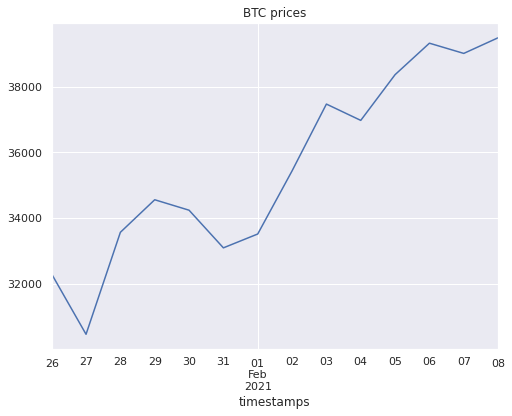

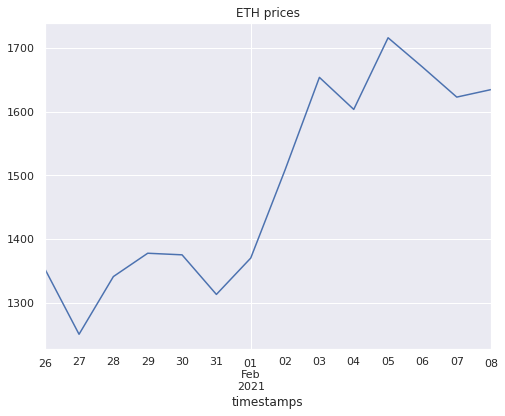

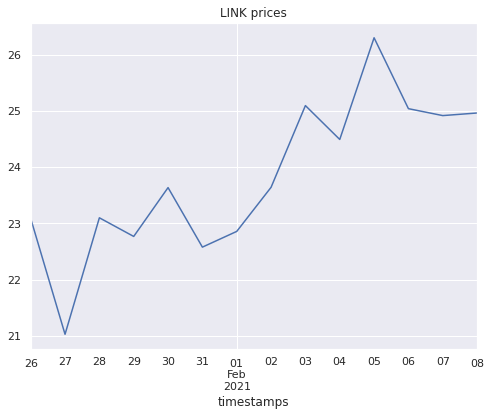

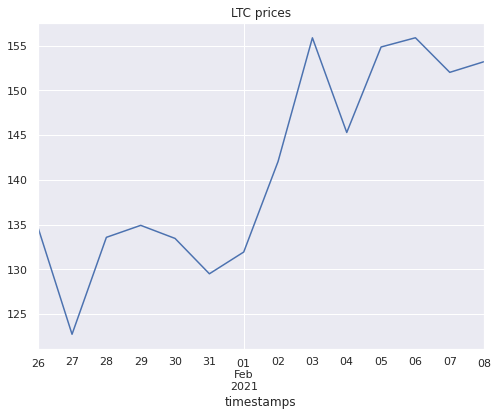

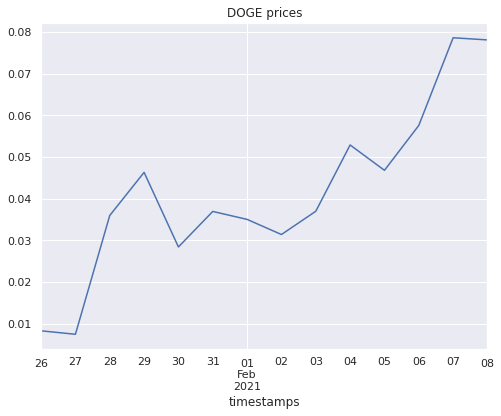

In [76]:
## plotting the data through pandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    # to have a nicer background on the plot
    sns.set()
    
    daily = crypto_final.filter(crypto_final.timestamps>'2021-01-25 00:00:00').toPandas()
    daily['prices']=pd.to_numeric(daily['prices'])
    daily['timestamps']=pd.to_datetime(daily['timestamps'])

    daily_btc = daily.loc[daily['currency'] == "BTC"]
    daily_eth = daily.loc[daily['currency'] == "ETH"]
    daily_link = daily.loc[daily['currency'] == "LINK"]
    daily_ltc = daily.loc[daily['currency'] == "LTC"]
    daily_doge = daily.loc[daily['currency'] == "DOGE"]


    daily_btc.plot(y='prices', x='timestamps',title='BTC prices', legend=None, figsize = (8,6))
    daily_eth.plot(y='prices', x='timestamps',title='ETH prices', legend=None,figsize = (8,6))
    daily_link.plot(y='prices', x='timestamps',title='LINK prices', legend=None, figsize = (8,6))
    daily_ltc.plot(y='prices', x='timestamps',title='LTC prices', legend=None, figsize = (8,6))
    daily_doge.plot(y='prices', x='timestamps',title='DOGE prices', legend=None, figsize = (8,6))
    
except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])

In [77]:
try:
    #we are only going to use the dates for which we have tweets
    #so we filter for those dates
    daily_btc = daily_btc[(daily_btc['timestamps'] >= '2021-02-01') & (daily_btc['timestamps'] <= '2021-02-05')]
    daily_eth = daily_eth[(daily_eth['timestamps'] >= '2021-02-01') & (daily_eth['timestamps'] <= '2021-02-05')]
    daily_link = daily_link[(daily_link['timestamps'] >= '2021-02-01') & (daily_link['timestamps'] <= '2021-02-05')]
    daily_ltc = daily_ltc[(daily_ltc['timestamps'] >= '2021-02-01') & (daily_ltc['timestamps'] <= '2021-02-05')]
    daily_doge = daily_doge[(daily_doge['timestamps'] >= '2021-02-01') & (daily_doge['timestamps'] <= '2021-02-05')]
    
except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])

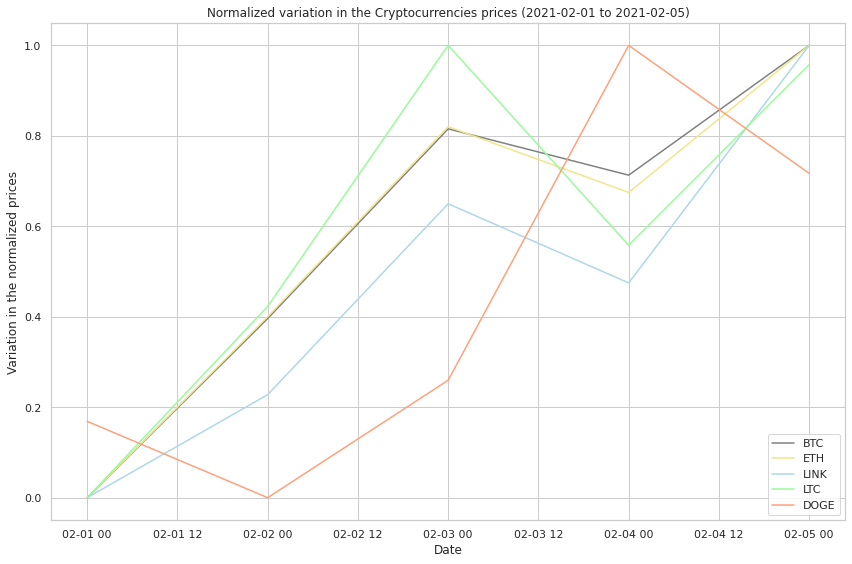

In [78]:
# importing package to normalize prices
from sklearn import preprocessing
try:
    # using Min-max normalization
    scaler = preprocessing.MinMaxScaler()
    btc_norm = scaler.fit_transform(daily_btc[["prices"]])
    eth_norm = scaler.fit_transform(daily_eth[["prices"]])
    link_norm = scaler.fit_transform(daily_link[["prices"]])
    ltc_norm = scaler.fit_transform(daily_ltc[["prices"]])
    doge_norm = scaler.fit_transform(daily_doge[["prices"]])

    # to have a nicer background on the plot
    sns.set(style = "whitegrid")
    
    # first we create a figure and the axes
    fig, ax = plt.subplots(figsize = (12,8))

    # filling the figure and axes
    ax.plot(daily_btc['timestamps'], btc_norm, color = "grey", label = "BTC")
    ax.plot(daily_eth['timestamps'], eth_norm, color = "khaki", label = "ETH")
    ax.plot(daily_link['timestamps'], link_norm, color = "lightblue", label = "LINK")
    ax.plot(daily_ltc['timestamps'], ltc_norm, color = "palegreen", label = "LTC")
    ax.plot(daily_doge['timestamps'], doge_norm, color = "lightsalmon", label = "DOGE")
    
    # setting labels for x and y axes
    ax.set_ylabel("Variation in the normalized prices")
    ax.set_xlabel("Date")
    
    # adding the title to the plot
    plt.title('Normalized variation in the Cryptocurrencies prices (2021-02-01 to 2021-02-05)')
    plt.legend(loc = 4)
    
    # to have a nicer output
    fig.tight_layout()
    
    plt.show()

except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])

## Preparing data for Machine Learning

In [25]:
try:
    #preparing the dataframe for the process
    #we use the partitioned df from preprocessing
    crypto_final = crypto_final.withColumn("prev_date", lag(crypto_final.timestamps).over(my_window))

    #exploding the timestamps to create a timeseries
    #we only select the id, currency, prices and difference columns
    crypto_minutes = crypto_final.select('id','currency','prices','difference', \
                                         explode(expr('sequence(prev_date, timestamps, interval 1 minute)')).alias("timestamps"))
    
    #computing the difference/minute
    crypto_minutes = crypto_minutes.withColumn("difference", crypto_final.difference/1440)

    #fixing the ID column
    crypto_minutes = crypto_minutes.withColumn("id", monotonically_increasing_id())
    
    # creating a categorical variable (to be used in ML)
    crypto_minutes = crypto_minutes.withColumn("category",crypto_minutes.difference>0)

    # commented: showing the resulting dataframe
    #crypto_minutes.show()
    
except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])

+---+--------+--------------+-----------------+-------------------+--------+
| id|currency|        prices|       difference|         timestamps|category|
+---+--------+--------------+-----------------+-------------------+--------+
|  0|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:00:00|    true|
|  1|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:01:00|    true|
|  2|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:02:00|    true|
|  3|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:03:00|    true|
|  4|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:04:00|    true|
|  5|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:05:00|    true|
|  6|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:06:00|    true|
|  7|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:07:00|    true|
|  8|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:08:00|    true|
|  9|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:09:00|    true|

In [80]:
try:
    # filtering the resulting dataframe by currencies, saving them in variables (to be used in ML)
    crypto_min_btc = crypto_minutes.filter(crypto_minutes["currency"]=='BTC')

    # showing the dataframes
    crypto_min_btc.show()

except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])

+---+--------+--------------+-----------------+-------------------+--------+
| id|currency|        prices|       difference|         timestamps|category|
+---+--------+--------------+-----------------+-------------------+--------+
|  0|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:00:00|    true|
|  1|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:01:00|    true|
|  2|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:02:00|    true|
|  3|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:03:00|    true|
|  4|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:04:00|    true|
|  5|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:05:00|    true|
|  6|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:06:00|    true|
|  7|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:07:00|    true|
|  8|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:08:00|    true|
|  9|     BTC|31732.66795884|1.479164423972222|2021-01-01 00:09:00|    true|

## Importing Sentiment Analysis Results

In [81]:
try:
    # reading the csv with sentiment analysis results
    sentiment_btc = spark.read.csv("sentiment_btc.csv", header=True)

    # drop extra columns
    sentiment_btc = sentiment_btc.drop('end','_c0')
    
except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])

In [82]:
try:
    # joining the bitcoin prices with the sentiment results
    data_ml = sentiment_btc.join(crypto_min_btc, sentiment_btc.start ==  crypto_min_btc.timestamps,"inner")

    # dropping extra columns
    data_ml = data_ml.drop('start','id')

    # inspecting the dataframe
    data_ml.show()

except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])

+------------------+--------+--------------+-------------------+-------------------+--------+
|    avg(sentiment)|currency|        prices|         difference|         timestamps|category|
+------------------+--------+--------------+-------------------+-------------------+--------+
|0.3333333333333333|     BTC|37472.07316651| 1.4111777149861156|2021-02-02 21:09:00|    true|
|               0.5|     BTC|37472.07316651| 1.4111777149861156|2021-02-02 21:10:00|    true|
|0.6666666666666666|     BTC|37472.07316651| 1.4111777149861156|2021-02-02 21:11:00|    true|
|0.6666666666666666|     BTC|36975.84320688|-0.3446041386319444|2021-02-03 10:33:00|   false|
|0.6666666666666666|     BTC|36975.84320688|-0.3446041386319444|2021-02-03 10:34:00|   false|
|               0.0|     BTC|36975.84320688|-0.3446041386319444|2021-02-03 10:35:00|   false|
|               0.5|     BTC|36975.84320688|-0.3446041386319444|2021-02-03 10:37:00|   false|
|               1.0|     BTC|36975.84320688|-0.3446041386319

# Logistic Regression

#### Additional Sources:
- Öğündür, G. (2020, May 12). Logistic Regression with PySpark. Medium. https://medium.com/swlh/logistic-regression-with-pyspark-60295d41221

In [83]:
try:
    # changing the type of the column we are trying to predict to ingeter 
    data_ml = data_ml.withColumn('increase', col('category').cast('integer'))
    
    # selecting the relevant columns for ML
    data_ml = data_ml.select('increase', col('avg(sentiment)').alias('sentiment'), 'prices')

    #data_ml.show()
    
except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])

In [84]:
## Import the DenseVector Module
from pyspark.ml.linalg import DenseVector

try:
    ## Use a lambda function to create an RDD with the label and a dense vector of features
    input_data = data_ml.rdd.map(lambda x: (x[0], DenseVector(x[1:])))

    ## Creates a :class:`DataFrame` from an :class:`RDD`, a list or a :class:`pandas.DataFrame`.
    df = spark.createDataFrame(input_data, ["label", "features"])
    
except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])

In [85]:
from pyspark.ml.feature import StandardScaler

try:
    ## Standardizes features by removing the mean and scaling to unit variance using column summary
    ## statistics on the samples in the training set.
    standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

    ## Fits a model to the input dataset with optional parameters.
    scaler = standardScaler.fit(df)

    ## Transforms the input dataset with optional parameters.
    scaled_df = scaler.transform(df)

    ## Prints the first row to the console.
    scaled_df.take(1)
    
except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])

In [86]:
try:
    ## Randomly splits this :class:`DataFrame` with the provided weights.
    train_data, test_data = scaled_df.randomSplit([.7,.3],seed=1808)

except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])

In [87]:
from pyspark.ml.classification import LogisticRegression

try:
    # creating & training the model
    lr = LogisticRegression(featuresCol = 'features_scaled', labelCol = 'label', maxIter=5)
    lrModel = lr.fit(train_data)

    # applying the model to testing data
    predictions = lrModel.transform(test_data)

    # showing the predictions
    predictions.show()
    
except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])

+-----+--------------------+--------------------+--------------------+--------------------+----------+
|label|            features|     features_scaled|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+--------------------+----------+
|    0|[0.33333333333333...|[1.05969866326891...|[-1.3497271274334...|[0.20591498670662...|       1.0|
|    0|[0.33333333333333...|[1.05969866326891...|[-1.3497271274334...|[0.20591498670662...|       1.0|
|    0|[1.0,36975.84320688]|[3.17909598980673...|[-1.3297572259357...|[0.20919952572534...|       1.0|
|    1|[0.0,38366.80565588]|[0.0,70.158361284...|[-1.3595303948312...|[0.20431663602885...|       1.0|
|    1|[0.0,38366.80565588]|[0.0,70.158361284...|[-1.3595303948312...|[0.20431663602885...|       1.0|
|    1|[0.0,38366.80565588]|[0.0,70.158361284...|[-1.3595303948312...|[0.20431663602885...|       1.0|
|    1|[0.0,38366.80565588]|[0.0,70.158361284...|[-1.3595303948312...|[0.

#### Evaluating the model

In [17]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

try:
    # creating an evaluator, calculating Test Area under ROC 
    evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
    print('Test Area under ROC: ', evaluator.evaluate(predictions))

    # calculating the accuracy of predictions
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
    print("Accuracy : ",accuracy)
    
except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])

Test Area under ROC:  0.696969696969697
Accuracy :  0.88
